In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg
import pydicom
import time
from skimage import io

In [2]:
PATH = "D:\\MRI_segmentation\\T1 3D\\SE12\\"

In [3]:
pi = np.pi

In [4]:
def read_file(direc, file, normalization):
    file = pydicom.read_file(direc+file)
    img = file.pixel_array
    if normalization == 1:
        data = img/(np.max(img)-np.min(img))  #normalization
    else:
        data = img
    return img, data

In [5]:
def initial_curve(center, width, img_size_row, img_size_col):
    initial_map = np.zeros((img_size_row,img_size_col))
    for i in range(len(initial_map)):
        for j in range(len(initial_map[0])):
            initial_map[i][j] = np.sqrt((i-center[0])**2+(j-center[1])**2)-width
    return initial_map

In [6]:
def force(image,s_gradient, mean1, mean2):
    edge_constrain = 1/(1+s_gradient)
    f1 = (image-mean1)**2
    f2 = (image-mean2)**2
    eps = 1e-5
    return (1/2+f1*edge_constrain)/((1+(f1+f2)*edge_constrain+2*eps)), (1/2+f2*edge_constrain)/((1+(f1+f2)*edge_constrain+2*eps)) 

In [7]:
def delta(phi, eps):
    return 1/pi*(eps/(phi**2+eps**2)) #分析最大值

In [8]:
def gradient_square(img):
    return (np.gradient(img)[1])**2+(np.gradient(img)[0])**2

In [9]:
def K(phi):
    phi_x = np.gradient(phi)[1]
    phi_y = np.gradient(phi)[0]
    phi_xx = np.gradient(phi_x)[1]
    phi_xy = np.gradient(phi_x)[0]
    phi_yy = np.gradient(phi_y)[0]
    
    return (phi_xx * phi_y**2 + phi_yy * phi_x**2 - 2*phi_xy * phi_y*phi_x)/((phi_x**2 + phi_y**2)**(3/2)+1e-10) 

In [10]:
def narrow(phi):
    phi[abs(phi)<1e-3] = 0
    return phi

In [22]:
def show_contour(img, phi):
    plt.clf()
    plt.imshow(img,cmap = plt.cm.bone)
    plt.contour(phi,[0],colors='r',linewidths = 0.5) 
    plt.show()

In [23]:
def evolution(data, phi, gamma1, gamma2, eta, gs_img, c1, c2, eps):
    f1, f2 = force(data, gs_img , c1, c2)
    curvature = K(phi)
    phi_t = phi - delta(phi,eps)*(gamma1*f1-gamma2*f2-eta*curvature)
    c1_t = np.mean(data[phi_t>0])
    c2_t = np.mean(data[phi_t<0])
    return c1_t, c2_t, phi_t, functional(gamma1, gamma2, eta, f1, f2, phi_t, eps)

In [24]:
def functional(gamma1, gamma2, eta, f1, f2, phi, eps):
     return np.sum((gamma1*f1*((phi>0).astype('int')))+gamma2*(f2*((phi<0).astype('int')))+eta*delta(phi, eps)*gradient_square(phi)**0.5)
    

In [67]:
import math
def psnr(img1, img2):
    mse = np.mean((img1-img2).astype(int))**2
    print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img1)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [37]:
center = np.array([270,300])
width = 15

In [170]:
def main(img, data, center, width):
    # img, data = read_file(PATH, 'IM150', 1)
    # img = pepper
    # data = img/(np.max(img)-np.min(img))
    img_size_row, img_size_col= len(img), len(img[0])
    phi = narrow(initial_curve(center, width, img_size_row, img_size_col))
    phi = phi/(np.max(phi)-np.min(phi))
    gs_img = gradient_square(data)

    c1 = np.mean(data[phi>0]) 
    c2 = np.mean(data[phi<0]) 
    start = time.time()
    energy_array = []
    for t in range(0,10001):
        c1_img = np.mean(img[phi>0]) 
        c2_img = np.mean(img[phi>0]) 
        c1_t, c2_t, phi_t, energy_t = evolution(data, phi, 0.1, 0.1, 0.01, gs_img, c1, c2, 0.5)
        energy_array.append(energy_t)
        c1_img_t = np.mean(img[phi>0]) 
        c2_img_t = np.mean(img[phi>0])
        error = np.sum(np.abs(phi-phi_t)**2)**(1/2)
        if t % 30 == 0:
            show_contour(img, phi)
            print(error)
    # #         print(abs(c2-c2_t))

        if t >10:
            if error<0.5:
                break
    #     print(np.sum(np.abs(phi-phi_t)**2)**(1/2))
        phi = phi_t        
        c1 = c1_t
        c2 = c2_t
    end = time.time()
    return phi

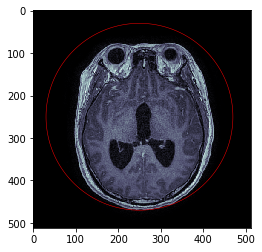

1.9071993831514407


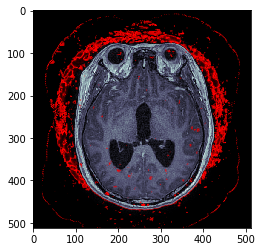

66.51177658866352


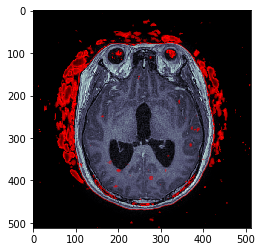

39.71460937192373


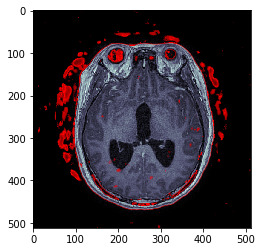

10.799787295707466


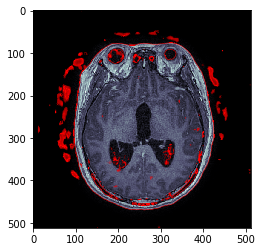

10.723889055568174


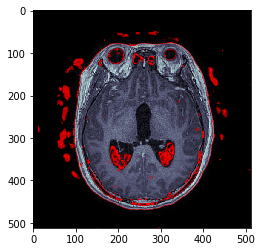

10.861532856817627


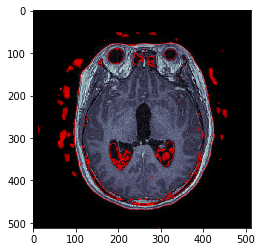

11.500440158116367


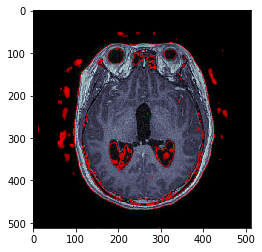

10.56087099043734


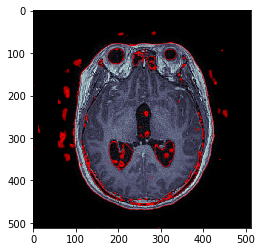

10.669506299820037


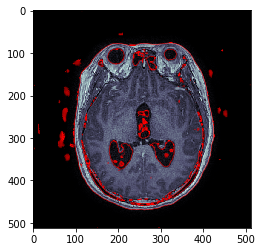

10.981991344007767


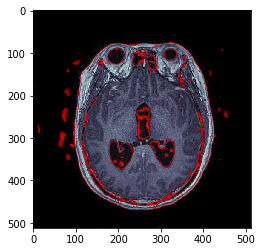

8.273292950825086


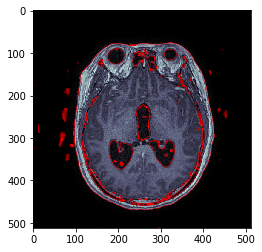

9.07719598295486


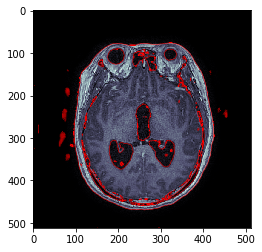

8.43770909383119


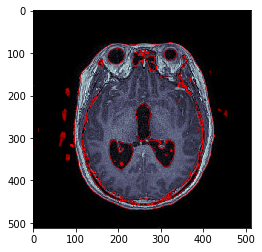

7.471916558162425


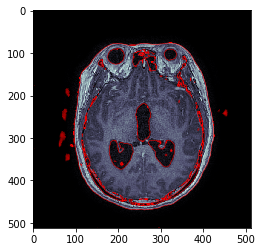

6.073072488263201


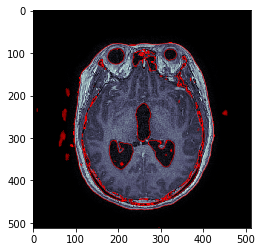

5.965534813089758


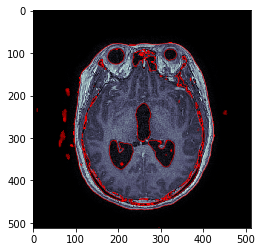

6.3014174814813275


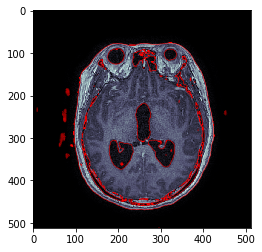

5.254841094200179


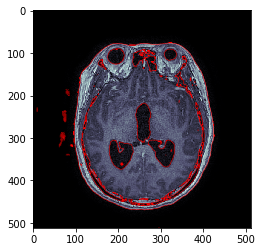

6.858056758013768


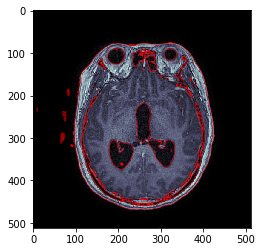

7.742835870112675


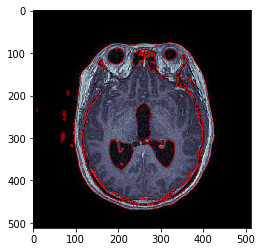

4.749979727353519


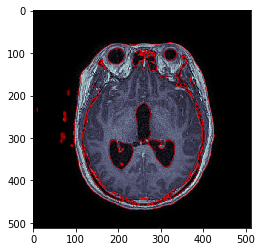

5.137675868609333


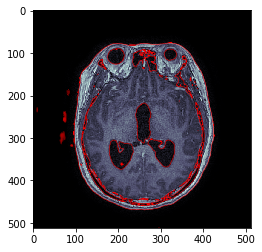

3.785247811021631


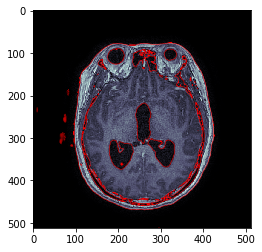

5.473709154606618


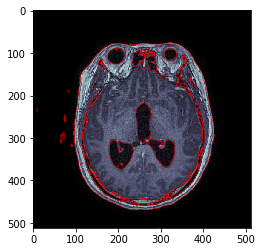

4.370734034572146


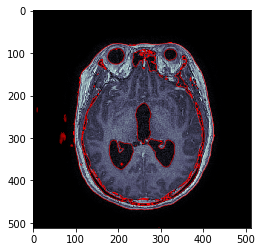

3.781512902964919


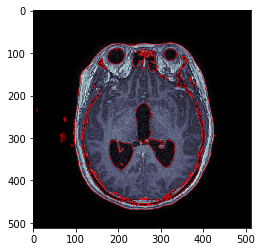

4.432701017116854


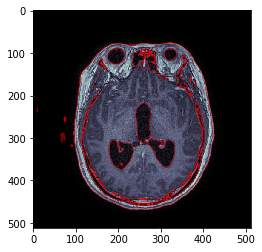

4.7248400107748045


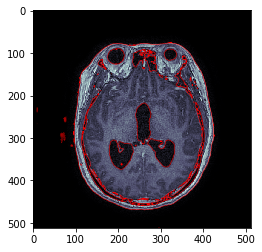

4.356370542941244


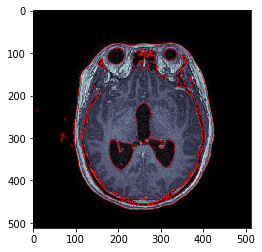

4.3975111617552765


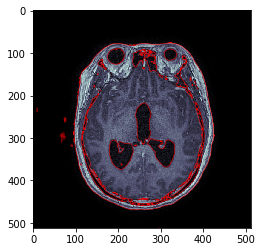

3.5939006320476823


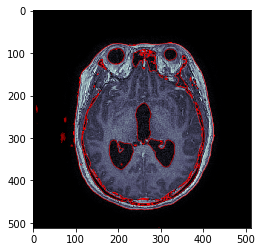

4.271768645713326


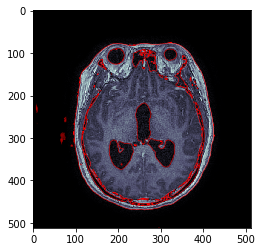

4.236102062324965


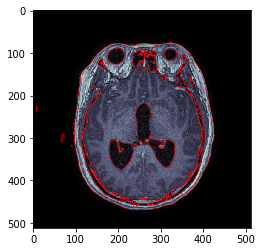

5.171911219389628


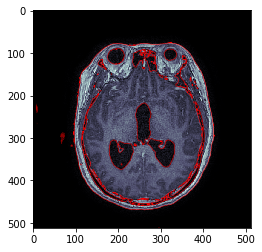

3.9436727338374906


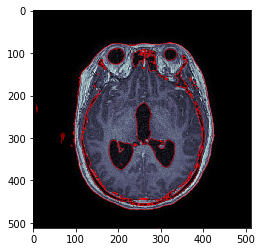

3.4715794702036766


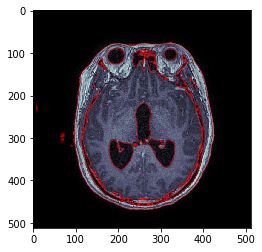

3.868990944211876


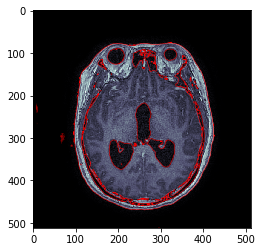

4.489023894867915


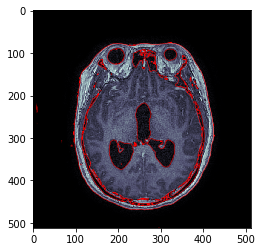

3.06601877584046


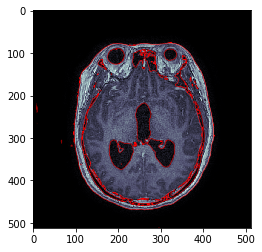

1.254155406802631


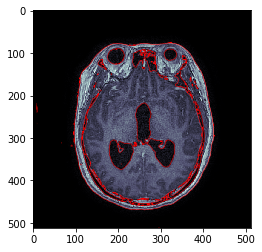

1.2199176474468332


In [110]:
img, data = read_file(PATH, 'IM120', 1)
ground_truth = main(img, data, [250,250], 220)

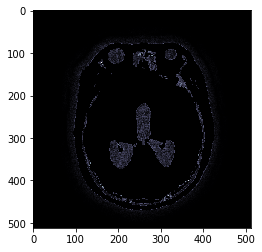

In [114]:
plt.imshow(img*(ground_truth>0).astype(int), cmap = plt.cm.bone)

In [45]:
def PepperandSalt(src,percetage):
    NoiseImg = np.copy(src)
    max_pixel = np.max(src)
    NoiseNum=int(percetage*src.shape[0]*src.shape[1])
    for i in range(NoiseNum):
        randX=np.random.random_integers(0,src.shape[0]-1)
        randY=np.random.random_integers(0,src.shape[1]-1)
        if np.random.random_integers(0,1)<=0.5:
            NoiseImg[randX,randY]=0
        else:
            NoiseImg[randX,randY]=max_pixel
            
    return NoiseImg
pepper = PepperandSalt(img, 0.2)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 511 + 1) instead
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 511 + 1) instead
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  


In [165]:
s = np.random.normal(500, 150, (512,512))
gaussian_noise = np.copy(img)+s.astype(int)

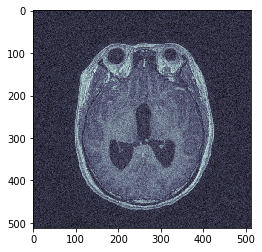

In [166]:
plt.imshow(gaussian_noise, cmap = plt.cm.bone)

In [167]:
d=psnr(img,gaussian_noise)
print(d)

249493.93159670435
12.187874204151205


In [168]:
plt.imsave('Gaussian_noise_SNR_'+str(round(d,2))+'.png', gaussian_noise,cmap = plt.cm.bone, dpi = 150)

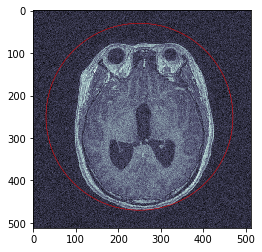

1.1139827334113883


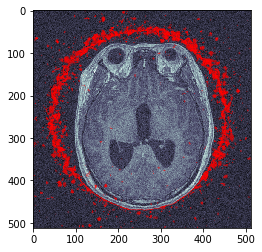

16.85756744446489


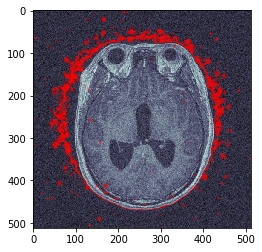

11.165437177266655


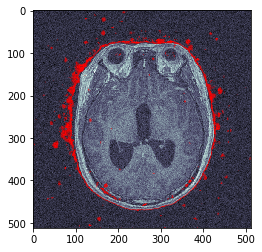

7.897732992464095


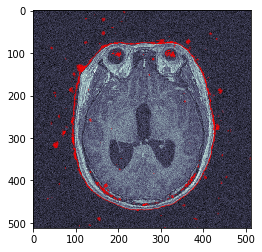

5.063623805799343


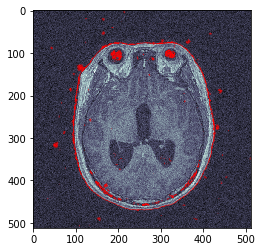

3.7413726933772895


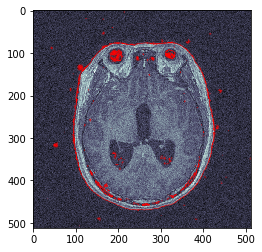

2.3871414121207337


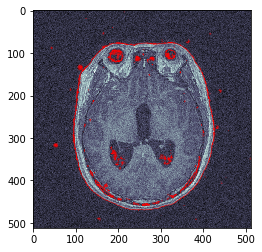

1.7860370187724435


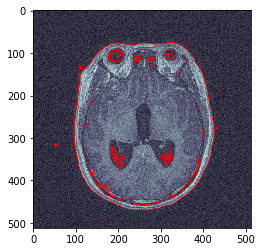

1.693089774136796


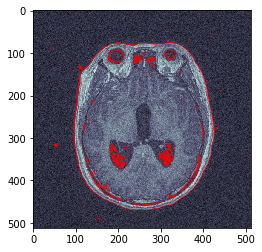

1.1448975698493764


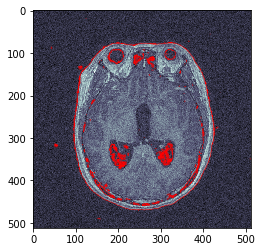

1.3533962321164983


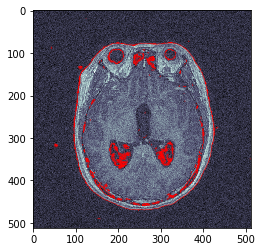

1.0595535612651226


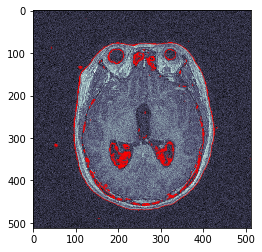

1.1848217740595088


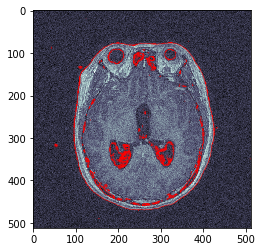

1.0769676512139919


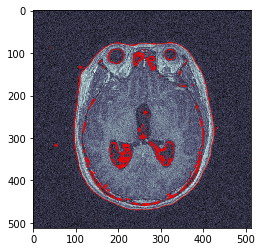

1.0527250169737488


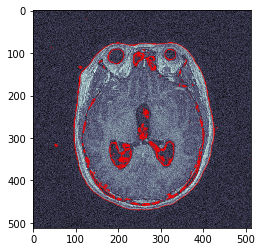

1.0295574021899032


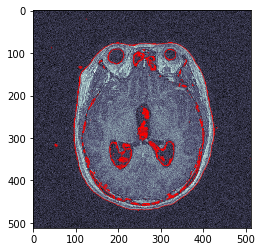

1.1567471379497754


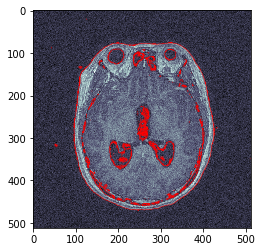

0.8412922144771299


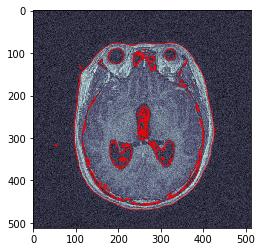

1.4195211568201132


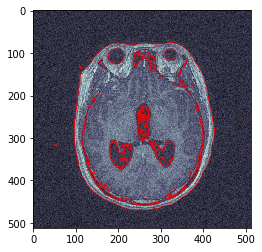

1.371659174818669


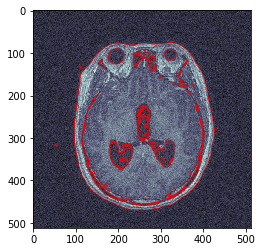

0.8867978227072637


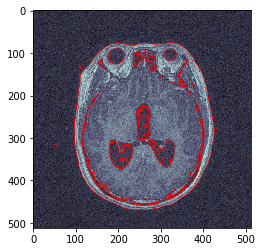

0.6851559370455589


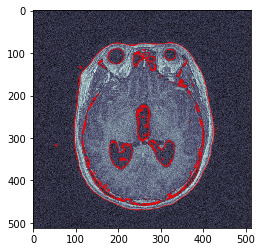

0.6313339545428612


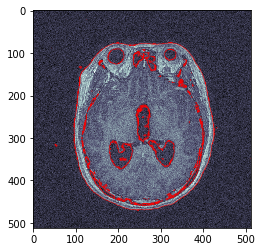

0.7073249183083941


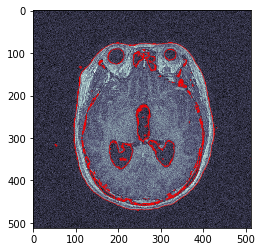

1.2847116176391706


In [171]:
test = main(gaussian_noise, gaussian_noise/(np.max(gaussian_noise)-np.min(gaussian_noise)),  [250,250], 220)

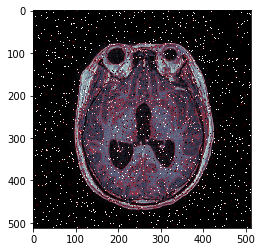

In [69]:
show_contour(pepper, test)

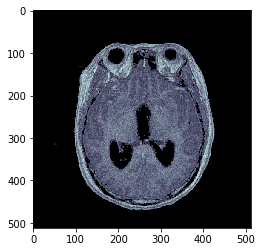

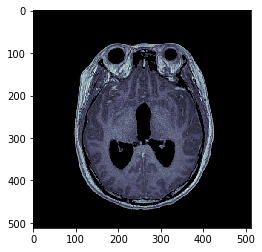

In [173]:
plt.clf()
plt.imshow(gaussian_noise*((test<0).astype(int)), cmap = plt.cm.bone)
plt.imsave( 'gaussian_noise_target.png',gaussian_noise*((test<0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()
plt.clf()
plt.imshow(img*((ground_truth<0).astype(int)), cmap = plt.cm.bone)
plt.imsave( 'IM120_back.png',img*((ground_truth>0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()

In [142]:
def dice_score(ground_truth, result):
    a = np.sum(((ground_truth<0)&(result<0)).astype(int))
    b = np.sum(((ground_truth<0)).astype(int))
    c = np.sum(((result<0)).astype(int))
    d = np.sum(((ground_truth<0)|(result<0)).astype(int))
    return 2*a/(b+c), a/d

In [143]:
dice_score(ground_truth, test)

(0.9761213606846428, 0.9533565045729947)

In [144]:
def SSIMnp(y_true , y_pred):
    u_true = np.mean(y_true)
    u_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.sqrt(var_true)
    std_pred = np.sqrt(var_pred)
    c1 = np.square(0.01*7)
    c2 = np.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

In [145]:
SSIMnp(img*((ground_truth<0).astype(int)), gaussian_noise*((test<0).astype(int)))

0.9841749620950987

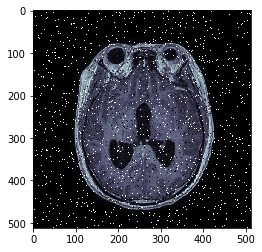

In [75]:
from skimage import io
noisy_img = io.imread('SNR_'+str(round(d,2))+'.png', as_gray=False)[:,:,0:3]
plt.imshow(noisy_img)

In [76]:
noisy_img[test<0]

Image([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

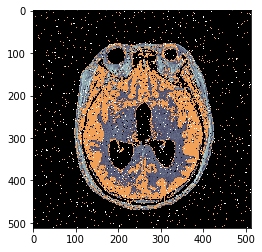

In [77]:
noisy_img[test>0] = [241,160,88]
noisy_img[pepper<350] = [0,0,0]
plt.imshow(noisy_img)

plt.imsave('SNR_'+str(round(d,2))+'result.png', noisy_img)

In [78]:
plt.imsave('IM120.png', img, cmap = plt.cm.bone, dpi = 150)

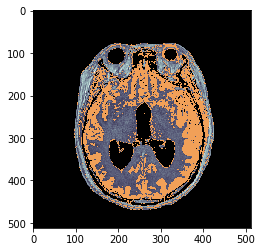

In [36]:
plt.clf()
clean_img = io.imread('IM120.png', as_gray=False)[:,:,0:3]
plt.imshow(clean_img)
clean_img[ground_truth>0] = [241,160,88]
clean_img[img<350] = [0,0,0]
plt.imshow(clean_img)

# plt.imsave('clean_with_SNR_'+str(round(d,2))+'result.png', clean_img)